<a href="https://colab.research.google.com/github/BluBloos/QMIND2020-2021/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runtime Verification and Google Drive Mount

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 20:57:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   2625MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Imports

In [26]:
############################
# just a bunch of imports
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import math
############################

# Import MNIST Data

In [27]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print("Train Images: {}".format(train_images.shape))

Train Images: (60000, 28, 28)


# Parameters

In [28]:
EPOCHS = 500
total_batch_size = train_images.shape[0]
m = 256 # BATCH SIZE
noise_dim = 100
examples = 16
seed = tf.random.normal(shape=[examples, noise_dim])


# Generate Dataset

In [29]:
# Generate the batched dataset
train_images = train_images.reshape(total_batch_size, 28, 28, 1).astype('float32')
 # Normalize the images to [-1, 1] to match the output of the generator (tanh activation)
train_images = (train_images - 127.5) / 127.5
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(total_batch_size)
train_dataset = train_dataset.batch(m, drop_remainder=True)


# Model Definition

In [30]:
# NOTE: Generator model is very diff from ours!
def make_generator_model():
    model = tf.keras.Sequential()
    # NOTE: use_bias just means whether there is a bias vector in computing the layer outputs
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    # What's going on with Batch norm?
    '''
    Applies a transformation that maintains the mean output close to 0 and the output
    standard deviation close to 1. Stablizes training. Still don't know how it works fully.
    '''
    model.add(layers.BatchNormalization())
    # So what's going on with the leaky relu?
    '''
    f(x) = alpha (0.3) * x if x < 0
    f(x) = x if x >= 0
    '''
    # It allows a small gradient when the unit is not active,
    # regular relu is a linear pass thru w/ all negative units truncated to zero
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

## Generator Test

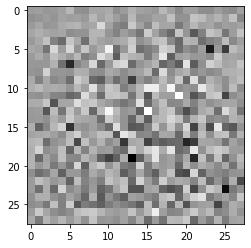

In [31]:
# test the generator!
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator Model

In [32]:
# NOTE: The discriminator model is also different!
def make_discriminator_model():
    model = tf.keras.Sequential()
    '''
    Kernel size of 5x5, stride of 2x2, 64 learned filters
    '''
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    '''
    Dropout only applies during training, randomly drops units. used
    to simulate multiple network architectures for fixing overfitting
    '''
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    #NOTE: There is no activation at the end of this! This means the data is raw
    # and not in the [0, 1] range, which means it can be termed "logit"
    model.add(layers.Dense(1))

    return model
    
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

## Descrim test

In [33]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00329705]], shape=(1, 1), dtype=float32)


## loss functions

In [34]:

# This method returns a helper function to compute cross entropy loss
# NOTE: From_logits=true means to assume that y_pred is a tensor of logits
'''
In maths, logit is a function that maps probabilities of [0, 1] to (-inf, inf).
Note that this is the inverse of the sigmoid function.
L = ln ( p / (1-p) )
In tensorflow it means to say the thing that is to be mapped to 0 -> 1 ?
'''

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Recall, discriminator wants to maximize log (D(x)) + log(1-D(G(z)))
def discriminator_loss(real_output, fake_output):
    # -log(real_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # -log(1-fake_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    # total_loss = - [ log(real_output) + log(1 - fake_output) ]
    # We can then agree that this loss function will maximize the loss
    # function as seen in the paper!
    return total_loss

def generator_loss(fake_output):
    # -log(fake_output)
    # We can then agree that this loss function will maximize log(D(G(z)))
    return cross_entropy(tf.ones_like(fake_output), fake_output)

'''
BIG NOTE: From logits is true, so for our custom loss functions we must apply sigmoid
'''

# the discriminator wants to maximize log(D(x)) + log(1-D(G(z)))
def discriminator_loss2(real_output, fake_output):
    #small_tensor_1 = tf.constant(tf.keras.backend.epsilon(), dtype=tf.float32, shape=fake_output.shape)
    #small_tensor_2 = tf.constant(tf.keras.backend.epsilon(), dtype=tf.float32, shape=real_output.shape)
    loss = tf.math.log(tf.math.sigmoid(real_output)) + tf.math.log1p(-tf.math.sigmoid(fake_output))
    loss = tf.math.reduce_mean(loss)
    return -loss;

# the generator wants to maximize log(D(G(z)))
def generator_loss2(fake_output):
    #small_tensor = tf.constant(tf.keras.backend.epsilon(), dtype=tf.float32, shape=fake_output.shape)
    # apply log to fake_output element-wise

    loss = tf.math.log(tf.math.sigmoid(fake_output))
    # adds up all the elements then divides by m
    loss = tf.math.reduce_mean(loss)
    return -loss;

## optimizers

In [35]:
# NOTE: Different optimizers are used
'''
TODO: Investigate the Adam optimizer
'''
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training Algo

In [36]:
checkpoint_dir = '/content/drive/My Drive/GAN-OUT/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# NOTE: The training step is different
@tf.function
def train_step(images):
    noise = tf.random.normal([m, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #gen_loss = generator_loss(fake_output)
      #disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss = generator_loss2(fake_output)
      disc_loss = discriminator_loss2(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #gradients_of_generator = [-x for x in gradients_of_generator]
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #gradients_of_discriminator = [-x for x in gradients_of_discriminator]

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## helper functions

In [37]:
FIG_DIR = '/content/drive/My Drive/GAN-OUT/'

def generate_and_save_images(save=False, show=True, uid=0):
    # BIG NOTE: The whole idea of these models is that they can do operations in parallel. This is the whole idea of batching,
    # and this is why in the summary the shapes all look like (None, ....), because the first tensor shape can be anything!
    # NOTE: In python it is possible to make class instances callable by overdding __call__. The training param
    # is used to make sure that the model computes like it would during training. Ex) Dropout is only applied during
    # the training phase.
    fake_images = generator(seed, training=False)
    #print("fake_images shape: {}".format(fake_images.shape))
    fig = plt.figure(figsize=(4,4))
    for i in range(fake_images.shape[0]):
        plt.subplot(4, 4, i+1)
        # Note that cmap maps from the [0, 1] range
        plt.imshow(fake_images[i, :, :, 0], cmap='gray')
        if save:
            plt.savefig(FIG_DIR + "Images/" + str(uid) + ".png")
    if show:
        plt.show()
    # clear the plot, so that all of them do not show at the end!
    plt.close()

def disc_accuracy():
    real_accuracy = 0
    fake_accuracy = 0

    better_test_images = test_images[0 : m, :, :]
    better_test_images = better_test_images.reshape(m, 28, 28, 1)

    noise = tf.random.normal([m, noise_dim])
    generated_images = generator(noise, training=False)
    real_output = discriminator(better_test_images, training=False)
    fake_output = discriminator(generated_images, training=False)

    arr = real_output.numpy()
    for x in arr:
        elem = x[0]
        if elem > 0.5:
            real_accuracy += 1
    # Note: The len(arr) should be equal to m
    real_accuracy = real_accuracy / len(arr)

    arr = fake_output.numpy()
    for x in arr:
        elem = x[0]
        if elem <= 0.5:
            fake_accuracy += 1
    # Note: The len(arr) should be equal to m
    fake_accuracy = fake_accuracy / len(arr)

    return (real_accuracy, fake_accuracy)

def test_losses():
    # Compute the loss function for a bunch of batches, then average the loss function!
    disc_loss = tf.constant(0, dtype=tf.float32)
    gen_loss = tf.constant(0, dtype=tf.float32)

    for image_batch in train_dataset:
        noise = tf.random.normal([m, noise_dim])
        generated_images = generator(noise, training=False)
        real_output = discriminator(image_batch, training=False)
        fake_output = discriminator(generated_images, training=False)
        disc_loss += discriminator_loss(real_output, fake_output)
        gen_loss += generator_loss(fake_output)

    disc_loss = disc_loss / math.floor(60000 / m)
    gen_loss = gen_loss / math.floor(60000 / m)

    return (disc_loss, gen_loss)

## train loop

In [ ]:
#####################
# Variables for history of loss and discriminator accuracy
a1_hist = []
a2_hist = []
d_hist = []
g_hist = []
#####################

# Maybe one of the only things that is still the same is this part of the code!
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Starting epoch {}".format(epoch + 1))
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(save=True, show=False, uid=epoch)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    print("Testing accuracy and recording loss!")
    start = time.time()

    a_real, a_fake = disc_accuracy()
    a1_hist.append(a_real)
    a2_hist.append(a_fake)

    disc_loss, gen_loss = test_losses()
    d_hist.append(disc_loss)
    g_hist.append(gen_loss)

    end = time.time()
    print("Done in {} seconds!".format(end-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(save=True, show=False, uid=epoch)

print("Starting training...")
train(train_dataset, EPOCHS)

Time for epoch 43 is 9.978853225708008 sec
Testing accuracy and recording loss!


## post training fun

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a1_hist, a2_hist):
	# plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d_hist, label='disc')
    plt.plot(g_hist, label='gen')
    plt.legend()

	# plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()

    plt.show()
    plt.close()

plot_history(d_hist, g_hist, a1_hist, a2_hist)

#######################
# generate the gif
print("Generating the GIF!")
png_dir = './Images/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('Images/movie.gif', images)
#################